# Train Resnet Model For Distracted Driver Detection

This notebook runs one training loop. It uses neptune.ml to log all information from the current experiment. 

### Requirements:

1.) To use this notebook, you have to set up a neptune.ml account. Follow the link for detailed instructions: https://docs.neptune.ml/python-api/tutorials/get-started.html

2.) You must already have created a clean_dataset by downloading the Prepare dataset.ipynb notebook.

### Configurations:

"namespace_project_name": your neptune namespace and project name<br>
"dir_dataset": path to clean data_set<br>
"trained_weights": optional path to pretrained weights<br>
"validation_set": name of the validation set image list<br>
"model": pretrained model for example models.resnet34 or models.resnet50<br>
"metric":  metrics you want to log<br>
"img_size": the size of the network input (images will be resized according to this image size)<br>
"batch_size": the size of one image batch<br>
"freeze": Set true if you want to freeze the pretrained model specified in "model"<br>

In [6]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [7]:
import neptune
from fastai.vision import *
from fastai.callbacks import *
from neptunecontrib.monitoring.fastai import NeptuneMonitor

In [8]:
CONFIG = {
    "namespace_project_name": "cpow-89/distracted-driver-detection",
    "dir_dataset": Path("./clean_dataset"),
    "trained_weights": None,
    "validation_set": "valid.txt",
    "model": models.resnet34,
    "metric": [error_rate, accuracy],
    "img_size": 252,
    "batch_size": 64,
    "freeze": False
}

In [9]:
# function for getting label information out of train file name
# Example: p002_c0_img_3370 -> c0
get_y_fn = lambda x: x.stem.split("_")[1]

In [10]:
# create Databunch
data = (ImageList.from_folder(CONFIG["dir_dataset"])
        .split_by_fname_file(CONFIG["validation_set"])
        .label_from_func(get_y_fn)
        .transform(get_transforms(do_flip=False), size=CONFIG["img_size"])
        .databunch(bs=CONFIG["batch_size"])
        .normalize(imagenet_stats)
    )

In [11]:
# create new experiment
neptune.init(CONFIG["namespace_project_name"])
driver_exp = neptune.create_experiment(name='disctracted driver detection using resnet',
                                       params=CONFIG, 
                                       upload_source_files=[])

https://ui.neptune.ml/cpow-89/distracted-driver-detection/e/DDD-36


In [12]:
# log current env settings
!conda env export > driver_env.yml
driver_exp.log_artifact("driver_env.yml")

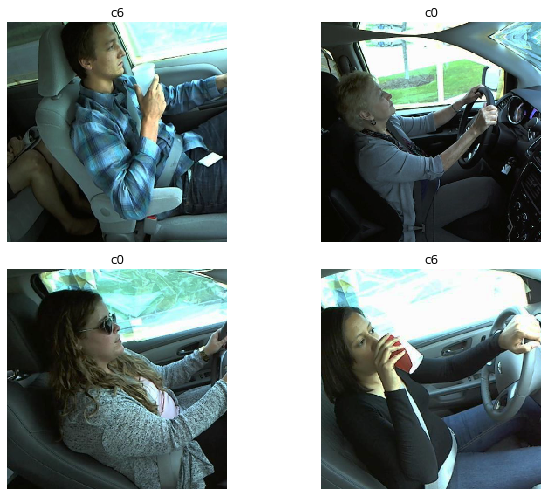

In [13]:
# Log Example images from train set
data.show_batch(2, figsize=(10,7))
driver_exp.log_image('Databunch_train_example', plt.gcf())

In [14]:
# create fast ai cnn learner 
learn = cnn_learner(data, CONFIG["model"], metrics=CONFIG["metric"])

if CONFIG["trained_weights"]:
    learn.load(CONFIG["trained_weights"])

if not CONFIG["freeze"]:
    learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


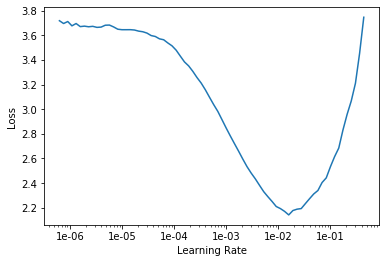

In [15]:
# plot and log Learning Rate Finder
learn.lr_find()
learn.recorder.plot()
driver_exp.log_image('Learning Rate Finder Plot', plt.gcf())

In [16]:
max_lr = slice(1e-4,1e-3)
driver_exp.set_property('max_lr', max_lr)
n_cycle = 10
driver_exp.set_property('n_cycle', n_cycle)

Experiment(DDD-36)

In [17]:
# run training loop and save model everytime the performance improve
learn.callbacks.append(NeptuneMonitor())
learn.fit_one_cycle(n_cycle, max_lr=max_lr, callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy')])

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.314393,0.405801,0.111609,0.888391,00:53
1,0.092976,0.379812,0.115621,0.884379,00:53
2,0.079682,0.243922,0.071732,0.928268,00:53
3,0.060496,0.184552,0.045540,0.954460,00:53
4,0.042475,0.158462,0.038697,0.961303,00:53
5,0.035520,0.217280,0.068429,0.931571,00:53
6,0.011692,0.200908,0.045540,0.954460,00:53
7,0.004006,0.178344,0.039641,0.960359,00:53
8,0.002626,0.131765,0.033506,0.966494,00:53
9,0.001166,0.120214,0.029967,0.970033,00:53


In [18]:
# log weights
# @ToDo: This logs the latest weights which are not always the best. Log best weights saved by SaveModelCallback
driver_exp.append_tag(CONFIG["model"].__name__)
freeze = "freeze" if CONFIG["freeze"] else "unfreeze"
weight_file_name = CONFIG["model"].__name__ + "_" + freeze + "_img_size_" + str(CONFIG["img_size"]) + "_" + driver_exp.id
learn.save(weight_file_name)
weight_file_name = weight_file_name + ".pth"
driver_exp.log_artifact(Path(CONFIG["dir_dataset"]/"models/"/weight_file_name))

In [19]:
driver_exp.stop()